In [24]:
import numpy as np
import pandas as pd
import xarray as xr
import proplot as plot

import warnings

warnings.filterwarnings('ignore')

# 1) 
### AWS

Plot time series of the meteorological variables from AWS. The AWS measures every ten minutes. 


In [134]:
AWS_data = (pd.read_csv('CR1000_1434_Minutt.dat',header=1).iloc[338:].drop(['RECORD',
                                                                            'ID',
                                                                            'BattV_Min',
                                                                            'BattV_TMn'],axis=1)
            .assign(time = lambda X : pd.to_datetime(X['TIMESTAMP'])).set_index('time')
            .drop('TIMESTAMP',axis=1)
            .apply(lambda x:x.astype(float))).resample('30T').mean()

In [26]:
AWS_data.head()

P         TA       TA_b         UU        FF  \
time                                                                      
2020-10-02 10:00:00   999.67  17.276471  17.264706  46.000000  4.629412   
2020-10-02 10:30:00   999.67  17.376667  17.426667  46.033333  3.906667   
2020-10-02 11:00:00   999.99  17.586667  17.496667  45.633333  4.413333   
2020-10-02 11:30:00   999.99  17.763333  17.683333  45.366667  3.663333   
2020-10-02 12:00:00  1000.65  18.020000  18.026667  44.433333  3.796667   

                            DD  RR_01      QSI_01  
time                                               
2020-10-02 10:00:00  87.882353    0.0  297.670588  
2020-10-02 10:30:00  87.266667    0.0  290.783333  
2020-10-02 11:00:00  88.666667    0.0  345.146667  
2020-10-02 11:30:00  78.166667    0.0  360.346667  
2020-10-02 12:00:00  78.500000    0.0  391.040000

In [68]:
AWS_wind= pd.DataFrame(pd.read_csv('CR1000_1434_Minutt.dat',header=1).iloc[338:].drop(['RECORD',
                                                                            'ID',
                                                                            'BattV_Min',
                                                                            'BattV_TMn'],axis=1)
            .assign(time = lambda X : pd.to_datetime(X['TIMESTAMP'])).set_index('time')
            .drop('TIMESTAMP',axis=1)
            .apply(lambda x:x.astype(float))).DD

In [29]:
def thermo_es(t):
    #Based on Renfrew and King 2000, modified by Kjersti.
    #Calculates saturation vapour pressure wtr water and ice; returns ice
    #first and then water from the polynomial approximation of Lowe (see Sargent 1980)

    #(ToC) (Temperature in centigrade)

    lowe_coef_ice = np.array([6.109177956, 5.03469897e-1, 1.886013408e-2,\
                     4.176223716e-4, 5.824720280e-6, 4.838803174e-8,\
                     1.838826904e-10])

    lowe_coef_water = np.array([6.107799961, 4.436518521e-1, 1.428945805e-2,\
                       2.650648471e-4,3.031240396e-6, 2.034080948e-8,\
                       6.136820929e-11])

    #Reverse the order of coefficient - does not have to do this in python!
    pesi = lowe_coef_ice[::-1]
    pesw = lowe_coef_water[::-1]


    esi = np.polyval(pesi,t)
    esw = np.polyval(pesw,t)

    #esi is saturation vapour pressure wtr to ice
    #esw is saturation vapour pressure wtr to water

    return esi,esw



def thermo_rh(tk,p,rh):
    #This function generates thermodynamic variables from T[K] p(mb) rh(%)
    #and gives out [theta, thetae, q, qsat, qsati]
    #Based on Renfrew and King 2000, modified by Kjersti 2018.

    #First; want all variables in SI-units
    p = p*100 #Converts from hPa to Pa


    #Calculate the potential temperature from temperature array
    p0 = 1000*100       #reference pressure in Pa
    R = 287             #gas constant
    cp = 1004           #Specific heat for air with respect to pressure
    K = R/cp            #kappa

    a = (p/p0)**(-K) #Constant for calculating the potential temperature
    theta = tk*a

    #calculate the equivalent potential temperature
 #   Lv = 2.5e6    #latent heat of vaporization
    eps = 0.622   #epsilon = Rd/Rv
 #   es0 = 0.611e3 #reference saturation vapour pressure Pa
 #   tk0 = 273.15  #reference temperature
    t = tk - 273.15
    #Function that calculates saturation vapour pressure wrt water and ice
    esi,es = thermo_es(t)

    es = es*100                #Convert to Pa
    esi = esi*100              #Convert to Pa
    rsat = eps*es/(p-es)       #Saturation mixing ratio wtr water

    rsati = eps*esi/(p-esi)    #saturation mixing ratio wtr ice

    e = es*rh / 100            #vapour pressure (Pa)

#    qsat = rsat/(rsat+1)       #sat specific humidity wrt water
#    qsati = rsati/(rsati+1) 	#sat specific humidity wrt ice


    #Calculate the water vapour mixing ratio, r; and specific humidity, q;
    r = eps*e/(p-e)
    q = r/(r+1)

    #Change the units to be g/kg
    Tlcl = 2840/(3.5*np.log(tk)-np.log(e/100)-4.805) + 55  # eqn 21, Bolton
    thetae = theta*np.exp(((3.376/Tlcl)-0.00254)\
                        *r*(1+0.81*r*1e-3)) # eqn 38, Bolton


    return thetae, q, r, rsat, rsati


In [30]:
_, q, _, _, _ = thermo_rh(AWS_data.TA+273.15,AWS_data.P,AWS_data.UU)

In [31]:
# Where P [P] = 0 is obviously just something wrong with the data: replace with NaN
# here I mask all the missing values with nans
AWS_data.P      = AWS_data.P.replace(0,np.nan)
AWS_data.TA     = AWS_data.TA.replace(-99.9,np.nan)
AWS_data.TA_b   = AWS_data.TA_b.replace(-99.9,np.nan)
AWS_data.UU     = AWS_data.UU.replace(-99.9,np.nan)
AWS_data.QSI_01 = AWS_data.where(AWS_data.QSI_01>0).QSI_01

# There is a spike in pressure and a massive drop in temperature, and the temperature measurements look weird before 338; 
# so therefore I remove all the vlaues befure this. 

In [32]:
AWS_data

P         TA       TA_b         UU        FF  \
time                                                                      
2020-10-02 10:00:00   999.67  17.276471  17.264706  46.000000  4.629412   
2020-10-02 10:30:00   999.67  17.376667  17.426667  46.033333  3.906667   
2020-10-02 11:00:00   999.99  17.586667  17.496667  45.633333  4.413333   
2020-10-02 11:30:00   999.99  17.763333  17.683333  45.366667  3.663333   
2020-10-02 12:00:00  1000.65  18.020000  18.026667  44.433333  3.796667   
...                      ...        ...        ...        ...       ...   
2020-10-16 07:30:00  1017.24   2.390000   1.890000  92.466667  0.343333   
2020-10-16 08:00:00  1017.06   4.280000   3.836667  87.733333  0.186667   
2020-10-16 08:30:00  1017.06   6.410000   6.043333  79.033333  0.103333   
2020-10-16 09:00:00  1017.23   7.163333   7.013333  70.633333  0.633333   
2020-10-16 09:30:00  1017.23   7.742105   7.542105  65.894737  0.942105   

                             DD  RR_01      QSI_01  
time                                                
2020-10-02 10:00:00   87.882353    0.0  297.670588  
2020-10-02 10:30:00   87.266667    0.0  290.783333  
2020-10-02 11:00:00   88.666667    0.0  345.146667  
2020-10-02 11:30:00   78.166667    0.0  360.346667  
2020-10-02 12:00:00   78.500000    0.0  391.040000  
...                         ...    ...         ...  
2020-10-16 07:30:00  211.633333    0.0  129.276667  
2020-10-16 08:00:00  181.333333    0.0  171.040000  
2020-10-16 08:30:00  215.500000    0.0  205.933333  
2020-10-16 09:00:00  136.466667    0.0  232.856667  
2020-10-16 09:30:00  127.631579    0.0  247.047368  

[672 rows x 8 columns]

there is no data gaps in the time series after I get rid of the first one in the AWS

### Kipp & Zonen: radiation data 1 min resolution 

In [33]:
KZ_rad = (pd.read_csv('TOA5_2068.Ett_min.dat',header=1).iloc[2:].drop('RECORD',axis=1).assign(time = lambda X : pd.to_datetime(X['TIMESTAMP'])).set_index('time')
            .drop('TIMESTAMP',axis=1)
            .apply(lambda x:x.astype(float))).resample('30T').mean()


In [34]:
KZ_rad.head()

KO_Wpm2_Avg  LO_Wpm2_Avg  KN_Wpm2_Avg  LN_Wpm2_Avg  \
time                                                                      
2020-09-22 11:00:00        0.809     1.635357    -0.064643     1.514571   
2020-09-22 11:30:00          NaN          NaN          NaN          NaN   
2020-09-22 12:00:00          NaN          NaN          NaN          NaN   
2020-09-22 12:30:00          NaN          NaN          NaN          NaN   
2020-09-22 13:00:00          NaN          NaN          NaN          NaN   

                     CNR1_gr_C_Avg  LOK_Wpm2_Avg  LNK_Wpm2_Avg  TP_deg_C_Avg  \
time                                                                           
2020-09-22 11:00:00         15.535    387.721429    387.578571     17.868571   
2020-09-22 11:30:00            NaN           NaN           NaN           NaN   
2020-09-22 12:00:00            NaN           NaN           NaN           NaN   
2020-09-22 12:30:00            NaN           NaN           NaN           NaN   
2020-09-22 13:00:00            NaN           NaN           NaN           NaN   

                     T1_deg_C_Avg  T2_deg_C_Avg  
time                                             
2020-09-22 11:00:00  -7961.714286    829.328571  
2020-09-22 11:30:00           NaN           NaN  
2020-09-22 12:00:00           NaN           NaN  
2020-09-22 12:30:00           NaN           NaN  
2020-09-22 13:00:00           NaN           NaN

In [35]:
# The field campaign starts the second of octorber, so need to get rid of the data before this
campaign_start_date = '2020-10-02'
KZ_rad = KZ_rad.query('index>=@campaign_start_date')

Calculate average albedo: 

In [36]:
KN_ = KZ_rad.where((KZ_rad.KO_Wpm2_Avg>1.7) & (KZ_rad.KN_Wpm2_Avg>1.7) & (KZ_rad.index.hour>5) & (KZ_rad.index.hour<17)).resample('30T').mean().KN_Wpm2_Avg
KO_ = KZ_rad.where((KZ_rad.KO_Wpm2_Avg>1.7) & (KZ_rad.KN_Wpm2_Avg>1.7) & (KZ_rad.index.hour>5) & (KZ_rad.index.hour<17)).resample('30T').mean().KO_Wpm2_Avg


(<matplotlib.lines.Line2D at 0x7fb9be41bfd0>,)

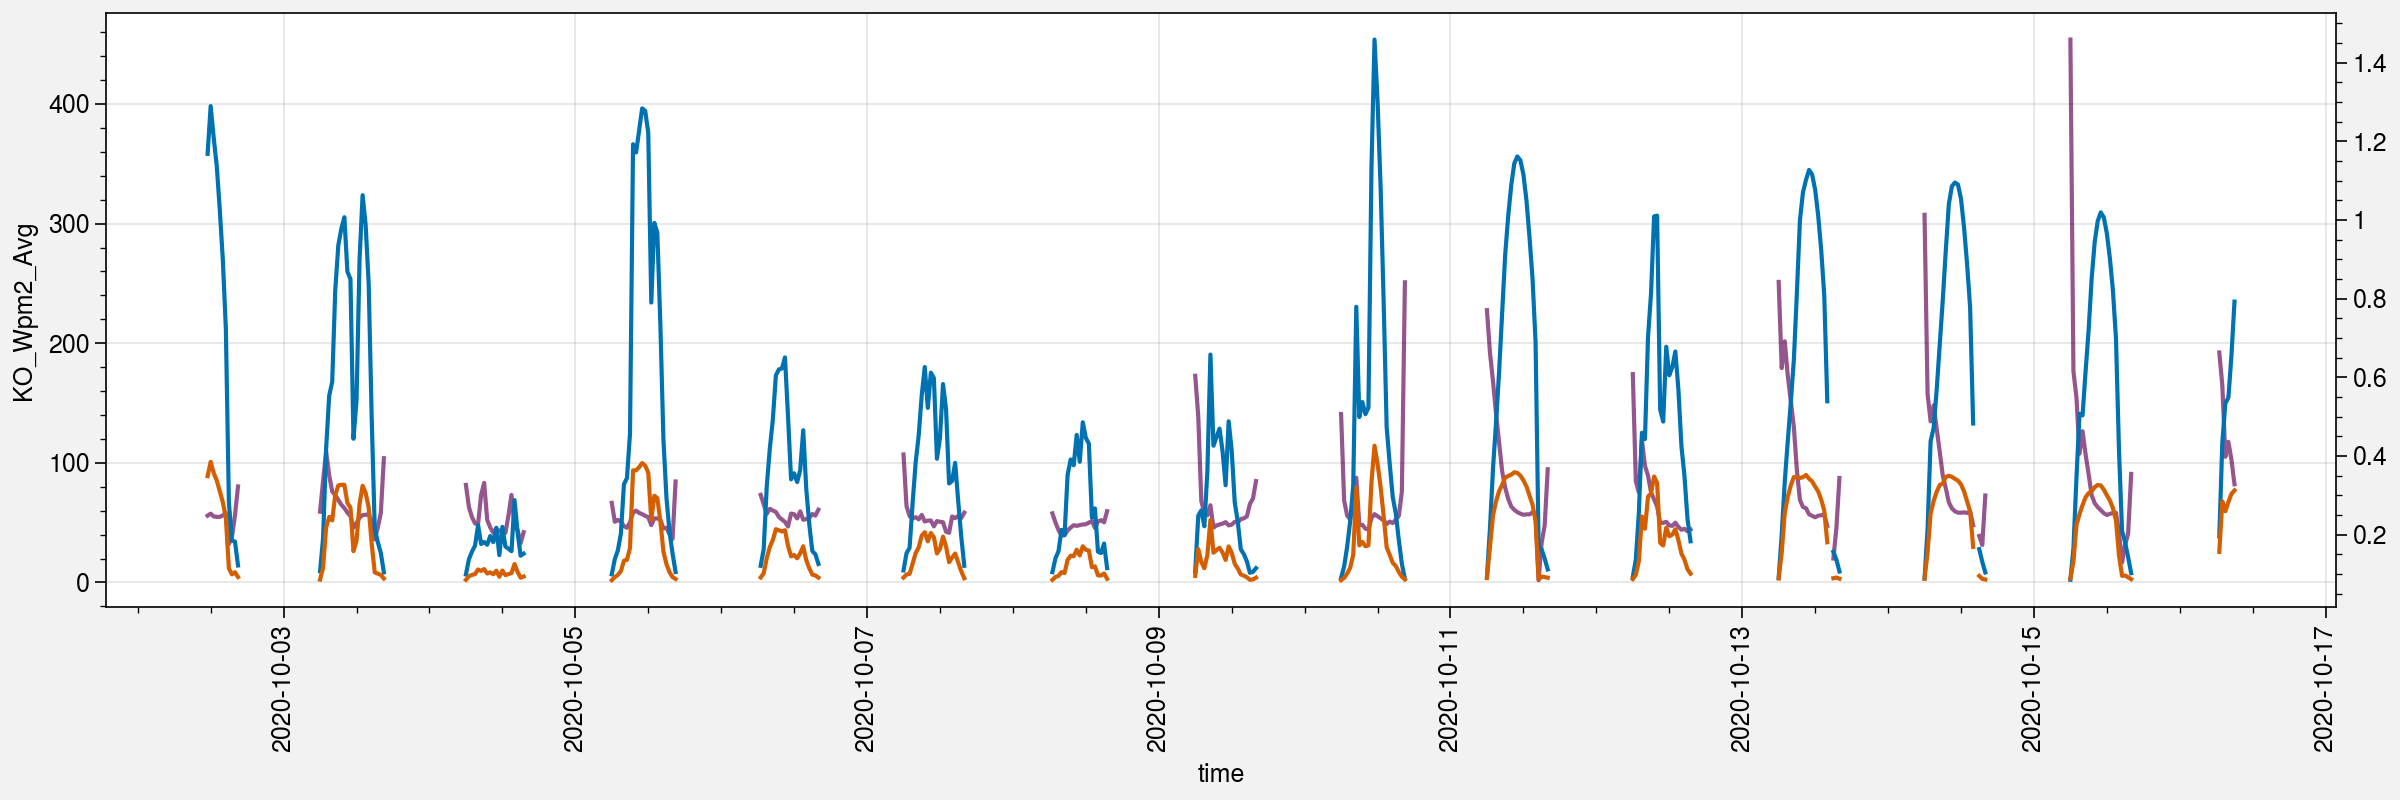

In [37]:
fig,ax = plot.subplots(figsize=(12,4))

ax.plot(KO_)
ax.plot(KN_)

ax.twinx().plot(KN_/KO_,color='purple')



#(KN_/KO_).plot(ax=ax.twinx())

In [38]:
albedo = KN_/KO_

In [39]:
albedo.where(albedo<1).mean()

0.28437719983947596

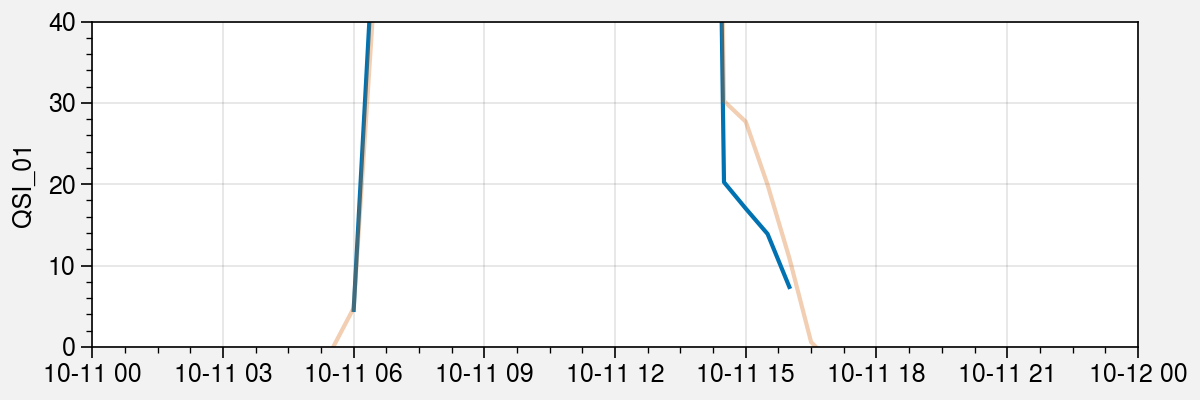

In [40]:
fig,ax = plot.subplots(figsize=(6,2),nrows=1)


ax[0].plot(AWS_data.QSI_01)
ax[0].plot(KZ_rad.KO_Wpm2_Avg,alpha=.3)

ax.format(xrotation=0,xlabel='')
ax.format(xlim=['2020-10-11','2020-10-12'],ylim=[0,40])

Radiation measurements are very similar between the two instruments. That's good. But on average, the Kipp&Zonen measures slightly more incoming radiation than the AWS. 

# Lidar

In [41]:
Z = pd.read_csv('Zephir_met_obs.csv').assign(time = lambda x: pd.to_datetime(x['Time and Date'])).set_index('time').drop('Time and Date',axis=1).resample('30T').mean()

In [42]:
Z.head()

Met Tilt (deg)  Met Compass Bearing (deg)  \
time                                                             
2020-10-02 10:30:00        1.084211                 349.771579   
2020-10-02 11:00:00        1.011236                 349.776404   
2020-10-02 11:30:00        1.146067                 349.541573   
2020-10-02 12:00:00        1.100000                 349.056667   
2020-10-02 12:30:00        1.044944                 349.125843   

                     Met Air Temp. (C)  Met Pressure (mbar)  Met Humidity (%)  \
time                                                                            
2020-10-02 10:30:00          17.246316           999.941463         48.610526   
2020-10-02 11:00:00          17.502247           999.958824         47.783146   
2020-10-02 11:30:00          17.924719          1000.000000         46.696629   
2020-10-02 12:00:00          18.267778                  NaN         45.744444   
2020-10-02 12:30:00          18.734831                  NaN         44.573034   

                     Met Wind Speed (m/s)  Met Wind Direction (deg)  
time                                                                 
2020-10-02 10:30:00              3.206884                 95.675789  
2020-10-02 11:00:00              3.876258                 97.008989  
2020-10-02 11:30:00              3.301708                100.874157  
2020-10-02 12:00:00              3.291256                100.496667  
2020-10-02 12:30:00              2.457719                104.935955

### Try to average some wind

In [168]:
dir_ = []
AWS_wind = pd.DataFrame(AWS_wind)
for day in AWS_data.index.day.unique():
    for hour in range(0,24): 
        count = np.histogram(AWS_wind.query('index.dt.day==@day and index.dt.hour==@hour').DD,bins=np.arange(0,360,5))
        idx_ = np.argmax(count[0])
        if count[0].sum()>0: 
            dir_.append(count[1][idx_])
        else:
            dir_.append(np.nan)

In [173]:
dates_ = pd.date_range('2020-10-02 00','2020-10-16 23',freq='H')

In [174]:
dates_

DatetimeIndex(['2020-10-02 00:00:00', '2020-10-02 01:00:00',
               '2020-10-02 02:00:00', '2020-10-02 03:00:00',
               '2020-10-02 04:00:00', '2020-10-02 05:00:00',
               '2020-10-02 06:00:00', '2020-10-02 07:00:00',
               '2020-10-02 08:00:00', '2020-10-02 09:00:00',
               ...
               '2020-10-16 14:00:00', '2020-10-16 15:00:00',
               '2020-10-16 16:00:00', '2020-10-16 17:00:00',
               '2020-10-16 18:00:00', '2020-10-16 19:00:00',
               '2020-10-16 20:00:00', '2020-10-16 21:00:00',
               '2020-10-16 22:00:00', '2020-10-16 23:00:00'],
              dtype='datetime64[ns]', length=360, freq='H')

In [179]:
DD_DAY = pd.DataFrame(index=dates_,columns=['DD'],data=np.array(dir_))

DD
2020-10-02 00:00:00 NaN
2020-10-02 01:00:00 NaN
2020-10-02 02:00:00 NaN
2020-10-02 03:00:00 NaN
2020-10-02 04:00:00 NaN
...                  ..
2020-10-16 19:00:00 NaN
2020-10-16 20:00:00 NaN
2020-10-16 21:00:00 NaN
2020-10-16 22:00:00 NaN
2020-10-16 23:00:00 NaN

[360 rows x 1 columns]

# Flux measurements

The Flux from the LICOR is measuring consistently higher values than the AWS. But if we in addition includes the LIDAR data, it is absolutely clear that it is the Sonic that is most likely measuring too high and is not calbrated correctly. 

# Plot the slow meteorology

In [101]:
def wind_dir(Ux,Uy,alpha=88): 
    a = np.arctan2(Uy,Ux)
    b = a*180./np.pi + 180. # mathematical wind angle ponting where the wind comes from
    c = 90. - b
    wdir = c+alpha+220
    wdir = wdir % 360
    return wdir

In [102]:
Ux = np.cos(np.deg2rad(AWS_wind)).resample('30T').mean()
Uy = np.sin(np.deg2rad(AWS_wind)).resample('30T').mean()

<AxesSubplot:xlabel='time'>

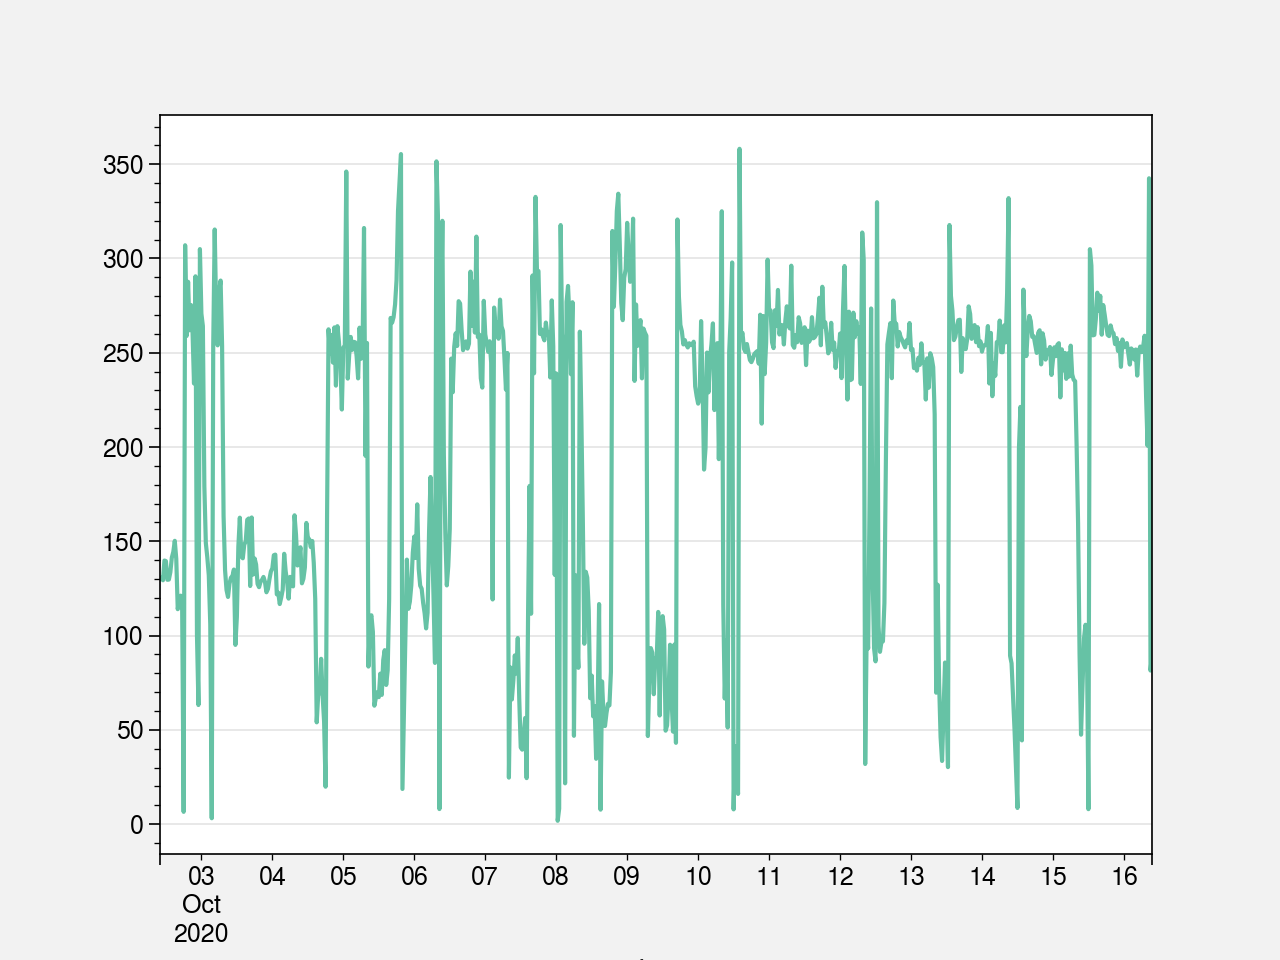

In [109]:
WindDir = wind_dir(Ux,Uy,alpha=88)
WindDir.plot()

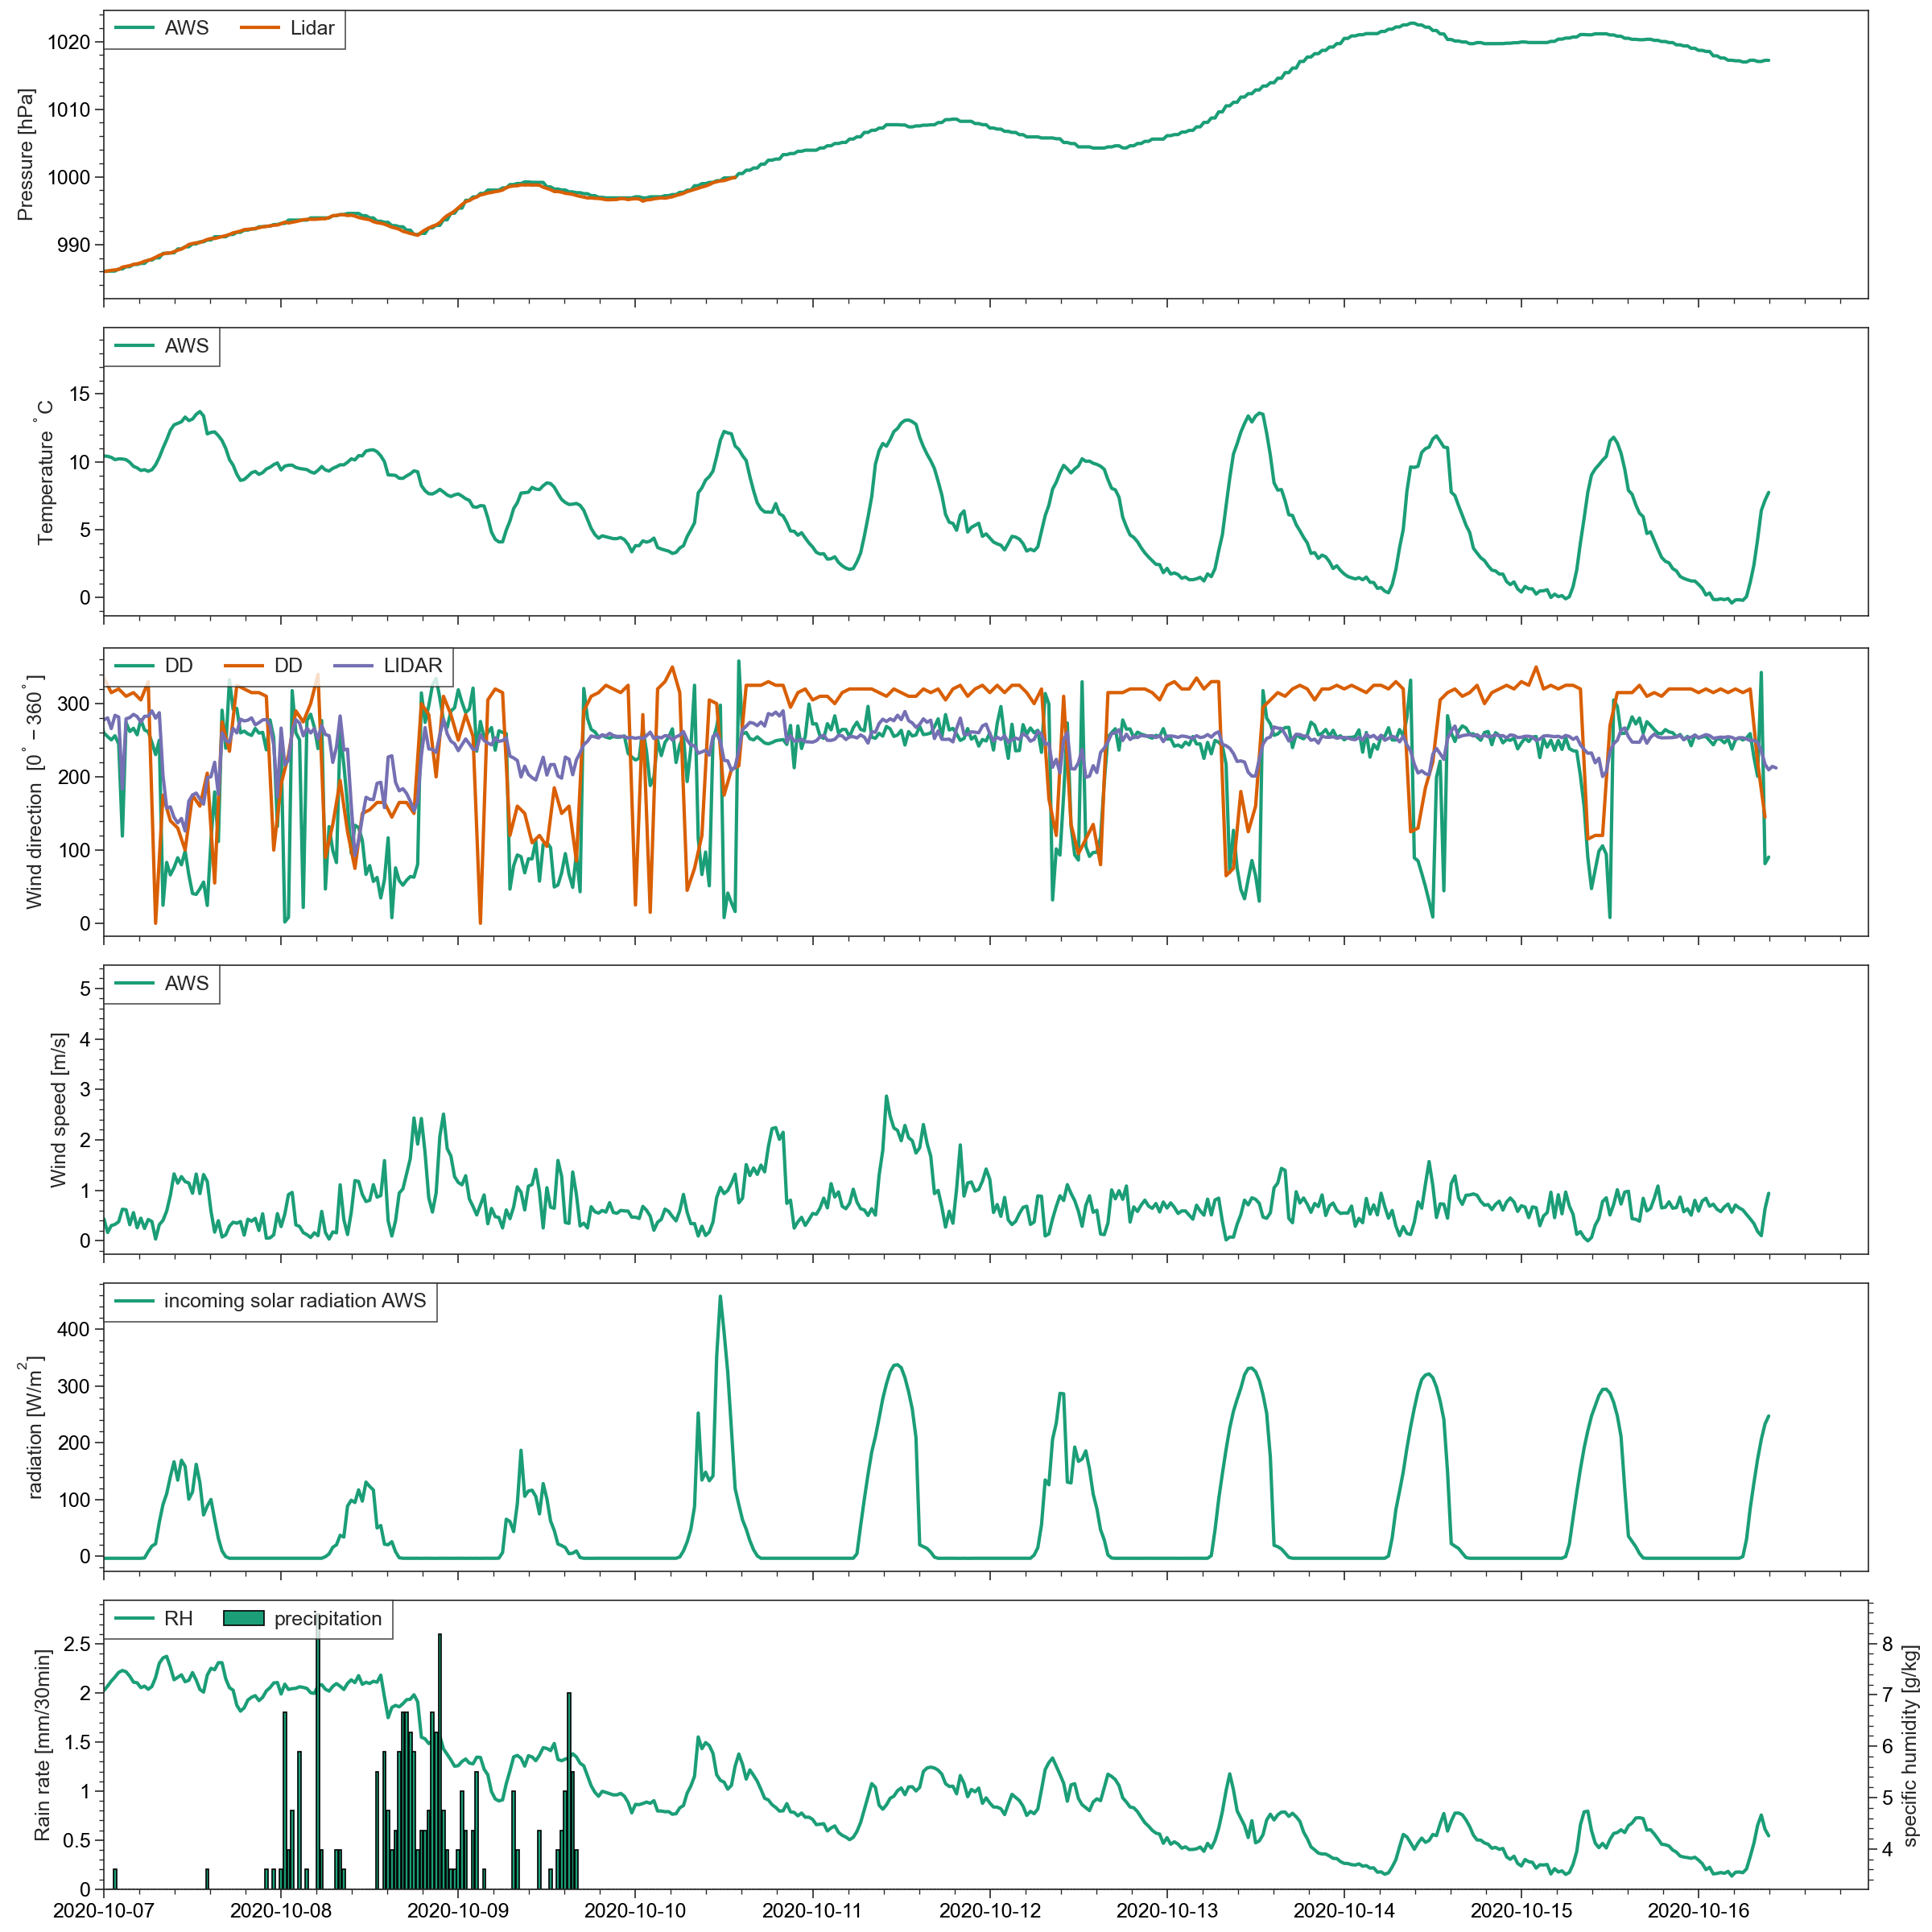

In [344]:
fig,axs = plot.subplots(nrows=6,figsize=(12,12),sharey=False)
plot.rc.cycle='Dark2'
ax = axs[0]
ax.format(ylabel='Pressure [hPa]')
ax.plot(AWS_data.P,label='AWS')
ax.plot(Z['Met Pressure (mbar)'],label='Lidar')

ax = axs[1]
ax.plot(AWS_data.TA,label='AWS')
ax.format(ylabel=r'Temperature $^\circ$C')

ax = axs[2]
#ax.plot(AWS_wind,label='Wind direction AWS')
ax.plot(WindDir)
ax.plot(DD_DAY)
ax.plot(Z['Met Wind Direction (deg)']-10,label='LIDAR')
ax.format(ylabel=r'Wind direction  $[0^\circ-360^\circ$]')


ax = axs[3]
ax.plot(AWS_data.FF,label='AWS')
#ax.plot(Z['Met Wind Speed (m/s)'],label='Lidar')
ax.format(ylabel='Wind speed [m/s]')


ax = axs[4]
ax.plot(AWS_data.QSI_01,labels='incoming solar radiation AWS')
ax.format(ylabel=r'radiation $[W/m^2]$')

ax = axs[5]
ax.bar(AWS_data.RR_01*30,label='precipitation')
ax.plot(np.nan,np.nan,label='RH')
ax.format(ylabel='Rain rate [mm/30min]')

axb = ax.twinx()
axb.plot(q*1e3,label='specific humidity')
axb.set_ylabel('specific humidity [g/kg]')


__ = axs.legend(loc='ul',frame=True)
axs.format(xrotation=0,xlabel='',xlim=['2020-10-07','2020-10-16 23'])

In [187]:
import numpy
import pandas
from matplotlib import pyplot
import seaborn


seaborn.set_style('ticks')



DD
time                      
2020-10-02 10:13:00   88.0
2020-10-02 10:14:00   87.0
2020-10-02 10:15:00   88.0
2020-10-02 10:16:00   88.0
2020-10-02 10:17:00   90.0
...                    ...
2020-10-16 09:44:00  121.0
2020-10-16 09:45:00  119.0
2020-10-16 09:46:00  116.0
2020-10-16 09:47:00  116.0
2020-10-16 09:48:00  119.0

[20136 rows x 1 columns]

In [326]:
kpdx = (pd.read_csv('CR1000_1434_Minutt.dat',header=1).iloc[338:].drop(['RECORD',
                                                                            'ID',
                                                                            'BattV_Min',
                                                                            'BattV_TMn'],axis=1)
            .assign(time = lambda X : pd.to_datetime(X['TIMESTAMP'])).set_index('time')
            .drop('TIMESTAMP',axis=1)
            .apply(lambda x:x.astype(float)))[['DD','FF']]

Of 5147 total observations, 176 have calm winds.


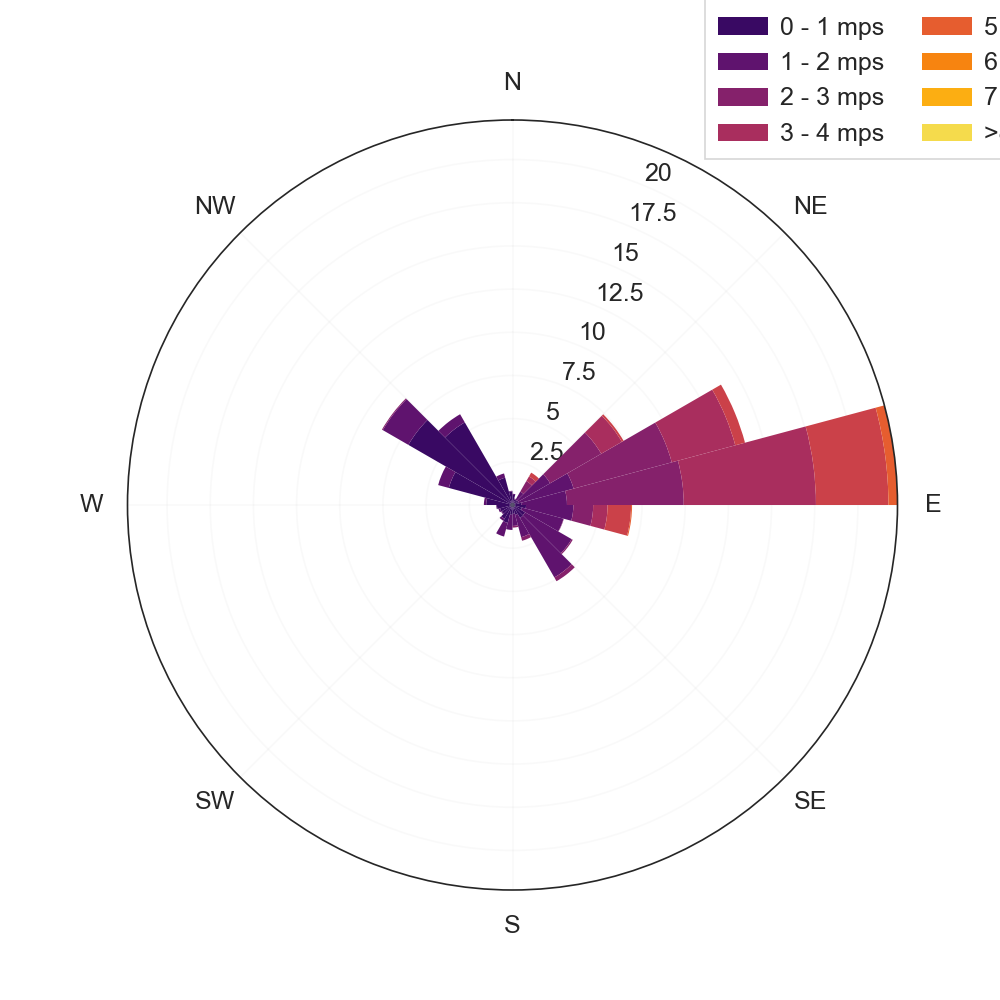

In [327]:
kpdx = kpdx.query('index.dt.day<6')

total_count = kpdx.shape[0]
calm_count = kpdx.query("FF == 0").shape[0]
print('Of {} total observations, {} have calm winds.'.format(total_count, calm_count))

def speed_labels(bins, units):   
    labels = []
    for left, right in zip(bins[:-1], bins[1:]):
        if left == bins[0]:
            labels.append('calm'.format(right))
        elif numpy.isinf(right):
            labels.append('>{} {}'.format(left, units))
        else:
            labels.append('{} - {} {}'.format(left, right, units))

    return list(labels)

def _convert_dir(directions, N=None):
    if N is None:
        N = directions.shape[0]
    barDir = directions * numpy.pi/180. - numpy.pi/N
    barWidth = 2 * numpy.pi / N
    return barDir, barWidth

spd_bins = [-1, 0, 1,2,3,4,5,6,7,8, numpy.inf]
spd_labels = speed_labels(spd_bins, units='mps')

dir_bins = numpy.arange(-7.5, 370, 15)
dir_labels = (dir_bins[:-1] + dir_bins[1:]) / 2

rose = (
    kpdx.assign(WindSpd_bins=lambda df:
            pandas.cut(df['FF'], bins=spd_bins, labels=spd_labels, right=True)
         )
        .assign(WindDir_bins=lambda df:
            pandas.cut(df['DD'], bins=dir_bins, labels=dir_labels, right=False)
         )
        .replace({'WindDir_bins': {360: 0}})
        .groupby(by=['WindSpd_bins', 'WindDir_bins'])
        .size()
        .unstack(level='WindSpd_bins')
        .fillna(0)
        .assign(calm=lambda df: calm_count / df.shape[0])
        .sort_index(axis=1)
        .applymap(lambda x: x / total_count * 100)
)

def wind_rose(rosedata, wind_dirs, palette=None):
    if palette is None:
        palette = seaborn.color_palette('inferno', n_colors=rosedata.shape[1])

    bar_dir, bar_width = _convert_dir(wind_dirs)

    fig, ax = pyplot.subplots(figsize=(5, 5), subplot_kw=dict(polar=True))
    ax.set_theta_direction('clockwise')
    ax.set_theta_zero_location('N')

    for n, (c1, c2) in enumerate(zip(rosedata.columns[:-1], rosedata.columns[1:])):
        if n == 0:
            # first column only
            ax.bar(bar_dir, rosedata[c1].values, 
                   width=bar_width,
                   color=palette[0],
                   edgecolor='none',
                   label=c1,
                   linewidth=0)

        # all other columns
        ax.bar(bar_dir, rosedata[c2].values, 
               width=bar_width, 
               bottom=rosedata.cumsum(axis=1)[c1].values,
               color=palette[n+1],
               edgecolor='none',
               label=c2,
               linewidth=0)

    leg = ax.legend(loc=(0.75, 0.95), ncol=2)
    xtl = ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
    
    return fig

directions = numpy.arange(0, 360, 15)
fig = wind_rose(rose, directions)

In [319]:
import matplotlib.pyplot as plt